# Cremer/Narla

We're following Narla *et al.* (PNAS 2021)to come to analytical approximations to the solution of the growth-expansion model of chemotaxis created by Cremer *et al.* (Nature 2020(?)). The Narla work is under very specific conditions that don't always apply. Specifically, they are that 

Equation 1:
$$ r \ll \lambda c $$

where $r$ is the growth rate (per hour), $\lambda$ is the attractant gradient the bacteria follow (*i.e.*, $a(x|t)\propto \exp (\lambda x)$), and $c$ is the speed of the taveling density bulge. This assumption is that growth is much slower than chemotactic drift, and ends up being 

Equation 2:
$$ \frac{\lambda}{\lambda_g} \gg 1 $$

which is to say the attractant slope is much steeper than the growth slope (*n.b.*, I'm not entirely sure this isn't already assuming Eqn. 1. I think it does).

## Useful Equations

Eqn. 12: $\lambda = \frac{c}{\chi_0-D_\rho}$

$c$ is the speed of the chemotaxis wave, $\chi_0$ is the Chemotactic Motility Parameter ($\mu m^2/s$), and $D_\rho$ is the Bacterial Motility Parameter ($\mu m^2/s$).


Eqn. 28: $\lambda_d \approx \frac{c}{D_\rho}$


Eqn. 36: $\lambda_g \approx \frac{r}{c}$

Definition of $z$:
$z \equiv x - ct$

Minimum of Eqn. 38:
$z_{min} = z_m + \frac{1}{\lambda} ln \frac{\lambda_g}{\lambda-\lambda_g}$
I've been defining $\lambda_c \equiv \lambda -\lambda_g$ 

Note that if you're not in the $\lambda \gg \lambda _g $ parameter regime, then $z_m$ can be either to the right or the left of $z_{min}$, so the diagram in Fig. 6a of Narla et al is a little misleading (as is Eqn. 39). Equation 39 comes about because when $\lambda \gg \lambda _g $, $z_{min}\approx z_m + \frac{1}{\lambda} ln \frac{\lambda_g}{\lambda} = z_m - \frac{1}{\lambda} ln \frac{\lambda}{\lambda_g} = z_m - \frac{1}{\lambda} ln \frac{\lambda}{1}\frac{c}{r}$, where the last step uses Eqn. 36.

# My model
Narla et al is difficult to apply and really only has piece-wise descriptions of certain regimes. Notably, it does not have a description of the density bulge. My model pulls together a few of the Narla descriptions and staples them together with a fake peak to cover the full radial density with just a few parameters.

There are four regions: growth, chemotaxis, "peak", and diffusion. Narla et al provide a description of the turnover between growth and chemotaxis, which is just a mixture of two exponentials facing different directions. They ignore the "peak". Finally, they say the diffusion is just an exponential decay 

I have a continuous form that covers all four regions. The trick is realized by using a logistic function to define where the joint growth-chemotaxis events take place, and where the turnover into the diffusion region occurs. Essentially the logistic function acts as an envelope to modulate the growth-chemotaxis region. Also, I place left and right cutoffs on the data to avoid any agar stab wounds and the petri dish edge. Also, all of this takes place on top of a floor (i.e., background, b), and with some scaling $\rho_0$. Note this doesn't really cover saturation of nutrition, but netiher does the Narla et al model.

## logistic/diffusion
It turns out that the tail of the logistic function looks a lot like the exponential diffusion decay. So the envelope not only describes the change over from the growth-chemotaxis to the diffusion (and thus creates the "peak" between chemotaxis and diffusion), it also provides the diffusion decay itself. In the diffusion region, we return to the Narla, and use Eqn. 27 which is the solution to the F-KPP equation. Thus, in that model the density is $y(x) = e^{\lambda_d (x-x-d)}$,  where this decays starts. Instead, we definte an evelope, $D$ of

$$ D(x|k_d,x_d) = 1 - \frac{1}{1+e^{-k_d(x-x_d)}} $$

Note how they combine as $x$ becomes $x>x_d$. Also note that adding in a separate exponential decay modulated by $1-D$ (i.e, defining where the growth-chemotaxis regime turns off instead of on) has the same functional form, so there's really no reason to do this as the current envelope is exact

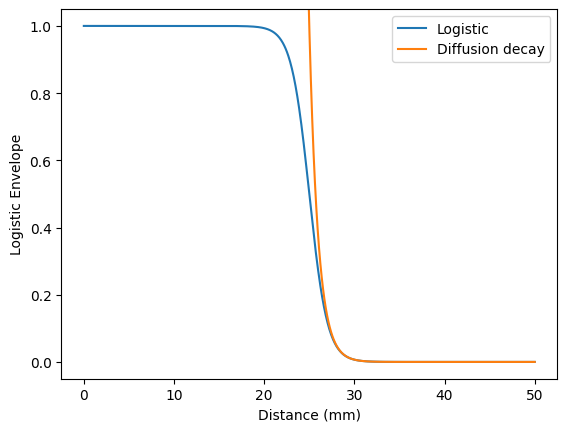

In [11]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0,50,1000)
kd = 1.
xd = 25.

## The (1 minus) logistic function
y = 1. - 1./(1.+np.exp(-kd*(x-xd)))

plt.plot(x,y,label='Logistic')
plt.plot(x,np.exp(-kd*(x-xd)),label='Diffusion decay')
plt.xlabel('Distance (mm)')
plt.ylabel('Logistic Envelope')
plt.ylim(-.05,1.05)
plt.legend()
plt.show()



## growth+chemotaxis
Following Eqn. 38 and expanding for a set time (and also redefining variables), you get

$$ y(x|k_g,k_c,x_g) = e^{-k_g (x-x_g)} + \exp{+k_c (x-x_g)},$$

where all $k_i$ are defined as positive (direction defined in equations), and here relative to Narla $k_c\equiv k-k_g$. Note that you should compare this to Eqn. "37.5" which says that in the chemotaxis regime ($a(z) > a_m$), then $\rho(z)=\beta a_m e^{(\lambda -\lambda_g)(z-z_m)}$, i.e., this is where we get $\lambda_c$.

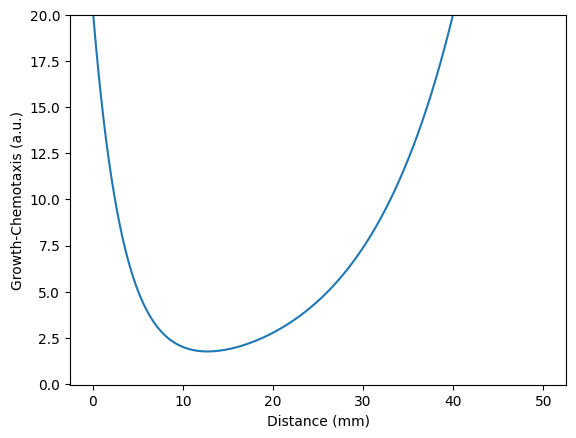

In [12]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0,50,1000)
kg = .3
kc = .1
xg = 10.

y = np.exp(-kg*(x-xg)) + np.exp(kc*(x-xg))

plt.plot(x,y)
plt.xlabel('Distance (mm)')
plt.ylabel('Growth-Chemotaxis (a.u.)')
plt.ylim(-.05,20)
plt.show()


## Growth-chemotaxis modulated by a logistic diffusion envelope
Combine these, we modulate the growth-chemotaxis form by multiplying it with the logistic diffusion envelope. We then ensure that this is normalized, so that a scaling ($\rho_0$) and offset ($b$) parameter can be used to describe the number of cells and the background scattering, respectively. This yields:

$$\rho (x\mid \rho_0, b, k_g, k_c, k_d, x_g, x_d) = \rho_0 \left( y(x|k_g,k_c,x_g) \cdot D(x|k_d,x_d) \right) + b,$$


Notably, according to this model the total number of cells along this line (in units defined by $\rho_0$) is

$$ N = \int_{\text{left edge}}^{\text{right edge}} dx\; \left( \rho (x\mid \rho_0, b, k_g, k_c, k_d, x_g, x_d) - b \right), $$

For the full plate, the left edge is $x=0$ and the right edge is  $x= \text{``plate edge"}$ is approximately 50 mm for standard Petri dishes but does not really matter as long as the bacteria have not grown too close to the edge (because the logistic function goes to zero). Earlier truncation of the left edge allows one to account for growth saturation, agar stab wounds, etc.

This integral can be done with the identity that 
$$ \int dx \;  e^{+a(x-b)}\left(1-\frac{1}{1+e^{-c(x-d)}}\right) = \frac{e^{a(x-b)}}{a}\cdot {}_{2}F_1 \left(1,\frac{a}{c};\frac{c+a}{c}; -e^{+c(x-d)} \right) $$

and evaluating the integral of the enveloped growth curve plus the integral of the enveloped chemotaxis curve, both from the left to the right edge.

Additionally, the minimum between the growth and chemotaxis regimes (under the assumption that $x \ll x_d$) is located at 

$$x_{\text{min}} \approx x_g + \frac{1}{k_g+k_c}\ln\frac{k_g}{k_c}$$

while the peak maximum (under the assumption that $x \gg x_g$ so that $e^{-k_g(x-x_g)}\approx 0$) is located at approximately 

$$x_{\text{max}} \approx x_d - \frac{1}{k_d}\ln\frac{k_d-k_c}{k_c}$$

Although a better guess seems to just be that $x_{\text{max}} \approx \frac{1}{2}\left(x_g+x_d\right)$.


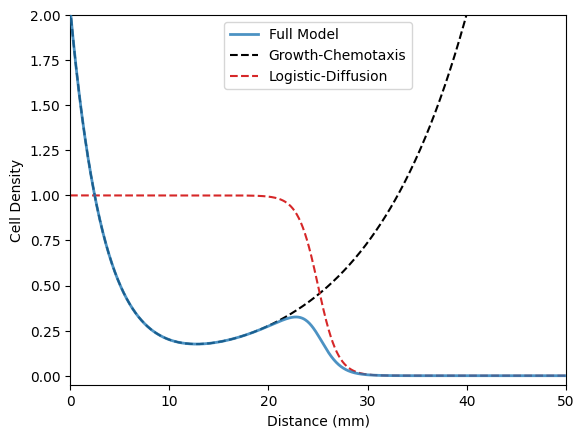

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from qcquant import fitting as qcqf

x = np.linspace(0,50,1000)

rho0 = 0.1
b = 0.
kg = .3
kc = .1
kd = 1.
xg = 10.
xd = 25.
theta = np.array((rho0,b,kg,kc,kd,xg,xd))

y_gc = np.exp(-kg*(x-xg)) + np.exp(kc*(x-xg))
y_d = 1. - 1./(1.+np.exp(-kd*(x-xd)))
y = qcqf.model(x,theta)


fig,ax = plt.subplots(1)

ylim = ax.get_ylim()
ax.plot(x,y,label='Full Model',color='tab:blue',zorder=5,alpha=.8,lw=2)
ax.plot(x,rho0*y_gc,'--',label='Growth-Chemotaxis',color='k')
ax.plot(x,y_d,'--',label='Logistic-Diffusion',color='tab:red')
ax.legend()
ax.set_ylim(-.05,2)
ax.set_xlim(0,50)
plt.xlabel('Distance (mm)')
plt.ylabel('Cell Density')
plt.show()